In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from collections import defaultdict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import math
%matplotlib inline

df_lis = pd.read_csv('listings.csv')

First I would like to know about the dimensions of each dataset. Also i would like to observe tha dataset.

## 1. Business Understanding

In [85]:
#Below code gives information about the number of columns and number of rows.
print(df_lis.shape)

(243, 92)


The listings show each house's informations so I would like to know more detail about this dataset, starting with the column names and data types of each house.

In [86]:
#Below code show the data types and the number of these data types in the dataset
df_lis.dtypes.value_counts()

object     61
float64    23
int64       8
Name: count, dtype: int64

In [87]:
#Below code show the name of the columns which are float64 data type
df_lis.dtypes[df_lis.dtypes=='float64']

zipcode                           float64
latitude                          float64
longitude                         float64
bathrooms                         float64
square_feet                       float64
guests_included                   float64
minimum_nights                    float64
maximum_nights                    float64
availability_30                   float64
availability_60                   float64
availability_90                   float64
availability_365                  float64
number_of_reviews                 float64
review_scores_rating              float64
review_scores_accuracy            float64
review_scores_cleanliness         float64
review_scores_checkin             float64
review_scores_communication       float64
review_scores_location            float64
review_scores_value               float64
license                           float64
calculated_host_listings_count    float64
reviews_per_month                 float64
dtype: object

In [88]:
#Below code show the name of the columns which are int64 data type
df_lis.dtypes[df_lis.dtypes=='int64']

id                           int64
scrape_id                    int64
host_id                      int64
host_listings_count          int64
host_total_listings_count    int64
accommodates                 int64
bedrooms                     int64
beds                         int64
dtype: object

In [89]:
#Below code show the name of the columns which are object data type
pd.set_option('display.max_rows', 92)
df_lis.dtypes[df_lis.dtypes=='object']

listing_url                         object
last_scraped                        object
name                                object
summary                             object
space                               object
description                         object
experiences_offered                 object
neighborhood_overview               object
notes                               object
transit                             object
thumbnail_url                       object
medium_url                          object
picture_url                         object
xl_picture_url                      object
host_url                            object
host_name                           object
host_since                          object
host_location                       object
host_about                          object
host_response_time                  object
host_response_rate                  object
host_acceptance_rate                object
host_is_superhost                   object
host_thumbn

There are many columns that are considered as object, but some of they should be treated as integer or float (especially those price columns shoul be number.) This is a type change problem that I will handle later. For now I would like to know about the number missing values and number of unique inputs in each column.

In [90]:
#Below code shows the number of missing values in each column in descending order
df_lis.isnull().sum().sort_values(ascending=False)

license                             243
square_feet                         235
monthly_price                       160
security_deposit                    117
weekly_price                        113
notes                               106
cleaning_fee                         69
thumbnail_url                        58
xl_picture_url                       58
medium_url                           58
host_about                           52
neighborhood_overview                51
transit                              50
host_acceptance_rate                 49
review_scores_accuracy               40
review_scores_location               39
review_scores_value                  39
review_scores_checkin                39
review_scores_cleanliness            38
review_scores_rating                 38
review_scores_communication          38
last_review                          37
first_review                         37
reviews_per_month                    37
space                                32


In [91]:
#Below code shows the columns names that do not have any missing values and all values are unique (different from each other) 
df_lis.nunique()[df_lis.nunique()==len(df_lis)]

id             243
listing_url    243
name           243
description    243
picture_url    243
latitude       243
longitude      243
dtype: int64

In [92]:
#Below code shows the columns names that have some missing values and number of unique values in that column
df_lis.nunique()[df_lis.nunique() != len(df_lis)].sort_values(ascending=False)

summary                             236
amenities                           236
space                               209
host_picture_url                    209
host_thumbnail_url                  209
host_id                             209
host_url                            209
host_since                          197
transit                             186
neighborhood_overview               185
thumbnail_url                       185
medium_url                          185
xl_picture_url                      185
first_review                        182
host_name                           172
reviews_per_month                   167
host_about                          157
notes                               135
availability_365                    134
street                              104
last_review                          97
price                                89
weekly_price                         83
number_of_reviews                    83
availability_90                      73


In [93]:
df_lis["amenities"].head(5)

0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object

#### Question-1

When I look dive into the dataset, I see **amenities** column which gives detailed information about features of the listing. I would like to know what are the most common amenities that are available in Seattle Airbnb dataset. So the question is there: What are the most common amenities?

##  2. Data Understanding

The code in the below cell creates the list of amenties available.

In [94]:
#I first create an empty list to fill with amenities available.
list_of_amenities = []

#I create a for loop to append all amenities values from the dataset into the list.
for i in range(len(df_lis)):
    list_of_amenities.append(df_lis['amenities'][i])

    
#In the dataset, every listing has a list of amenities, so in order to take unique amenities from the whole dataset
#I use the below code. I use the "set" function to make the amenities unique and than convert the set into a list
#to remain consistency of data type.
list_of_amenities = list((s.strip('\'\{\}') for s in list_of_amenities))
list_of_amenities_string = ",".join(list_of_amenities)
list_of_amenities = list(set(list_of_amenities_string.split(",")))

#After execution the above lines in this cell, we have an empty string in the list of amenties.
#We have to remove that one from the list.
without_empty_list_of_amenities = []
for string in list_of_amenities:
    if (string != ""):
        without_empty_list_of_amenities.append(string)
list_of_amenities = without_empty_list_of_amenities

The code in the below cell is taken from one of the Udacity lecture notes (named: HowToBreakIntoTheField.py).
This function is used to count the number of listings that contains each amenity in the amenities list.

In [95]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of amenities
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the amenity is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [96]:
df_lis.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [97]:
study

,amenities,count
0,{},3
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",2
2,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",2
3,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",2
4,"{""Wireless Internet"",""Pets live on this proper...",2
...,...,...
231,"{Internet,""Wireless Internet"",Heating,""Smoke D...",1
232,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1
233,"{""Wireless Internet"",Kitchen,""Free Parking on ...",1
234,"{TV,Internet,""Wireless Internet"",Kitchen,Heati...",1


In [98]:
df_lis['amenities'].value_counts().reset_index()

,amenities,count
0,{},3
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",2
2,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",2
3,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",2
4,"{""Wireless Internet"",""Pets live on this proper...",2
...,...,...
231,"{Internet,""Wireless Internet"",Heating,""Smoke D...",1
232,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1
233,"{""Wireless Internet"",Kitchen,""Free Parking on ...",1
234,"{TV,Internet,""Wireless Internet"",Kitchen,Heati...",1


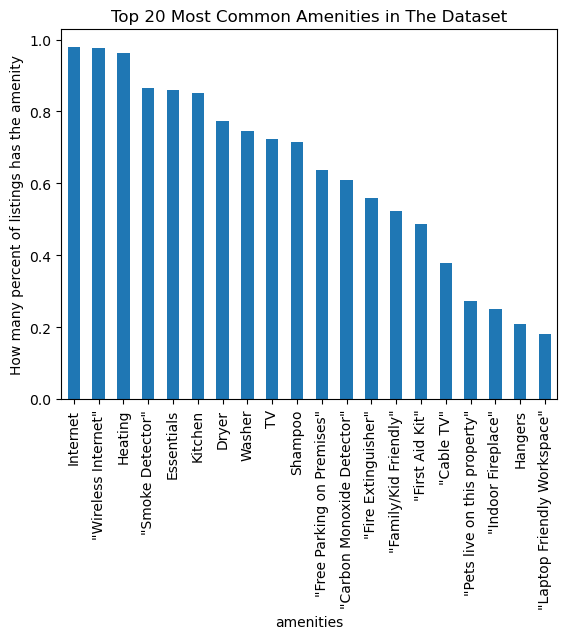

In [99]:
#I create a dataframe named study, which has lists of amenities as one column and the count of these amenities lists
#in our main (df_lis)
study = df_lis['amenities'].value_counts().reset_index()
#study.rename(columns={'index': 'amenities', 'amenities': 'count'}, inplace=True)

#Here with the total_count function, I count the number of listings that contains each amenity in the amenities list.
study_df = total_count(study, 'amenities', 'count', list_of_amenities)
study_df.set_index('amenities', inplace=True)

#Here I create a bar chart to show the percentage of each amenity from the most common to the least common.
(study_df/len(df_lis))[:20].plot(kind='bar', legend=None);
plt.title('Top 20 Most Common Amenities in The Dataset');
plt.ylabel('How many percent of listings has the amenity')
plt.show()

In the above chart you can see that the most common amenities in Seattle listings are:
- Internet
- Wireless Internet
- Heating
- Smoke Detector
- Essentials



Whereas the least common amenities in Seattle listings are:
- Lock on Bedroom Door
- Doorman
- Smoking Allowed
- Other pet(s)
- Washer / Dryer

#### Question-2

When I look dive into the dataset, I see some important features of listings. Some of these features have seperate columns (for example property_type or room_type) and some of these features are in **amenities** column. What I would like to know about this dataset is, "What attracts the guests most for renting a property?". I will try to answer this question below.

In order to understand the popularity of a listing I will use the **availability_30** column. Because it gives an idea about the booking ratio (or popularity) of the property.

In [100]:
df_lis["availability_30"]

0      14.0
1      13.0
2       1.0
3       0.0
4      30.0
       ... 
238     0.0
239    30.0
240     3.0
241    23.0
242     NaN
Name: availability_30, Length: 243, dtype: float64

In [101]:
#Check if availability_30 column has an missing values. I will use this columns for booking_ratio_30.
df_lis['availability_30'].isnull().sum()

1

In [102]:
df_lis["availability_30"] = df_lis["availability_30"].fillna(df_lis["availability_30"].median())

In [103]:
#Check if availability_30 column has an missing values. I will use this columns for booking_ratio_30.
df_lis['availability_30'].isnull().sum();

In [104]:
#Below code, creates the column 'booking_ratio_30' which gives info about the booking percentage in the next 30 days
df_lis['booking_ratio_30'] = 1 - (df_lis['availability_30']/30)

In [105]:
#Show the first five rows of the new column
df_lis['booking_ratio_30'].head()

0    0.533333
1    0.566667
2    0.966667
3    1.000000
4    0.000000
Name: booking_ratio_30, dtype: float64

Above, I found a percantage on booking ratio of each listing. Now I will have to make seperate columns for each of the features that I will investige whether they attract the guests for choosing the listing to rent.

First feature I would like to investigate is **room_type**.

In [106]:
#Below code checks if the 'room_type' column has any missing values.
#Since the result of the code is zero, the column does not have any missing values. 
df_lis['room_type'].isnull().sum()

0

In [107]:
#Below code shows the number of each unique values in the 'room_type' column.
df_lis['room_type'].value_counts().sort_values(ascending=False)

room_type
Entire home/apt    173
Private room        69
Shared room          1
Name: count, dtype: int64

Above, I found that there is not any missing values in the room_type column and also there are three different types of rooms. How about these different rooms booking ratios?

In [108]:
#Below code shows information about booking ratios of different room types for next 30 days
df_lis.groupby(['room_type'])['booking_ratio_30'].mean().sort_values(ascending=False)

room_type
Entire home/apt    0.524374
Private room       0.412077
Shared room        0.000000
Name: booking_ratio_30, dtype: float64

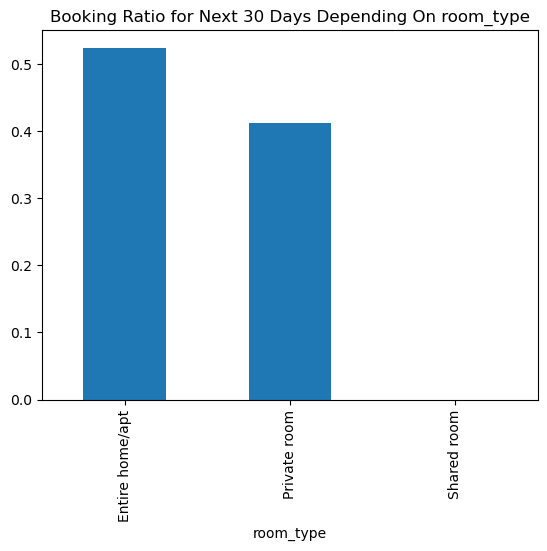

In [109]:
#Below code plots a bar chart to visualize booking ratios of different room types for next 30 days
(df_lis.groupby(['room_type'])['booking_ratio_30'].mean().sort_values(ascending=False)).plot(kind='bar', legend=None)
plt.title('Booking Ratio for Next 30 Days Depending On room_type');
plt.show()

In [110]:
#Below code shows the unique property types and count of each one
df_lis['property_type'].value_counts().sort_values(ascending=False)

property_type
House          119
Apartment       99
Townhouse       10
Condominium      5
Camper/RV        3
Bungalow         3
Cabin            2
Loft             1
Boat             1
Name: count, dtype: int64

In [111]:
#Below code shows information about booking ratios of different property types for next 30 days
df_lis.groupby(['property_type'])['booking_ratio_30'].mean().sort_values(ascending=False)

property_type
Apartment      0.525758
Townhouse      0.513333
House          0.480112
Cabin          0.466667
Condominium    0.460000
Loft           0.433333
Camper/RV      0.244444
Bungalow       0.144444
Boat           0.000000
Name: booking_ratio_30, dtype: float64

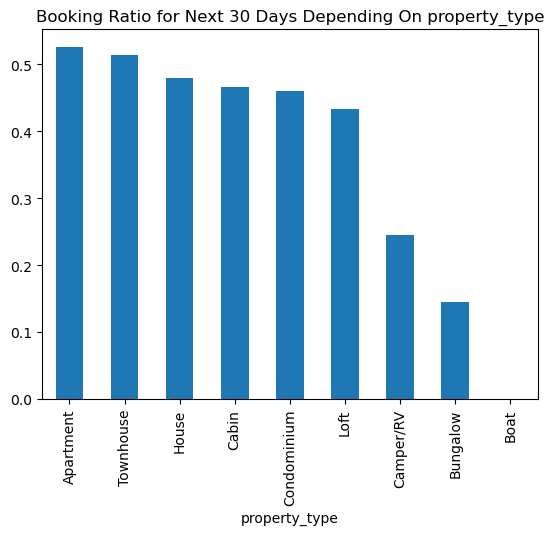

In [112]:
#Below code plots the booking ratios of different property types for next 30 days
(df_lis.groupby(['property_type'])['booking_ratio_30'].mean().sort_values(ascending=False)).plot(kind='bar', legend=None)
plt.title('Booking Ratio for Next 30 Days Depending On property_type');
plt.show()

How about the **amenities** and their effect for attracting the guest? In order to answer the first question I had created the list of amenities which will be useful here to answer the second question.

In [113]:
#Check if amenities column has an missing values.
df_lis['amenities'].isnull().sum()

0

In [114]:
#Here I create new columns for each of the amenities and fill them all with zeros.
for i in range(len(list_of_amenities)):
    df_lis[list_of_amenities[i]] = 0

In [115]:
#Here I fill the new amenities columns, by first checking if the listing has that amenity.
#If the listing has that amenity I fill it with 1 and if it does not have it, I fill it with zero.
for i in range(len(list_of_amenities)):
    for t in range(len(df_lis)):
        if list_of_amenities[i] in df_lis['amenities'][t]:
            df_lis.loc[t , list_of_amenities[i]] = 1
        else:
            df_lis.loc[t , list_of_amenities[i]] = 0

In [116]:
#Here I create a dataframe that will contain information about booking ratio of listings that contain the amenity.
amenities_importance = pd.DataFrame(index=range(0,len(list_of_amenities)), columns = ["Amenity_Name", "Booking Ratio for HAVING the Amenity", "Booking Ratio for NOT HAVING the Amenity", "Booking Difference"])


#In the below for loop, I write the name of the amenity, calculate the booking ratio of listings that contain the amenitiy
#and calculate the booking ratio of listings that do not contain the amenitiy
#and calculate the difference between booking ratios for each amenity. 
for i in range(len(list_of_amenities)):
    amenities_importance['Amenity_Name'][i] = list_of_amenities[i]
    amenities_importance['Booking Ratio for HAVING the Amenity'][i] = df_lis.groupby([list_of_amenities[i]])['booking_ratio_30'].mean()[1]
    amenities_importance['Booking Ratio for NOT HAVING the Amenity'][i] = df_lis.groupby([list_of_amenities[i]])['booking_ratio_30'].mean()[0]
    amenities_importance['Booking Difference'][i] = amenities_importance['Booking Ratio for HAVING the Amenity'][i] - amenities_importance['Booking Ratio for NOT HAVING the Amenity'][i]

amenities_importance.set_index('Amenity_Name', inplace=True)

In [117]:

#Here I list the Top 10 booking difference to see which amenities are most prefered by guests.
amenities_importance.sort_values(by='Booking Difference', ascending = False)[:10]

,Booking Ratio for HAVING the Amenity,Booking Ratio for NOT HAVING the Amenity,Booking Difference
Amenity_Name,,,
Kitchen,0.514815,0.349537,0.165278
"""Hot Tub""",0.624242,0.48398,0.140263
Washer,0.523389,0.393817,0.129571
Dryer,0.51117,0.419091,0.092079
"""Wireless Internet""",0.492194,0.416667,0.075527
"""Smoke Detector""",0.499444,0.432323,0.067121
"""Cable TV""",0.524275,0.469647,0.054629
"""Family/Kid Friendly""",0.514961,0.463362,0.051599
Cat(s),0.532,0.48555,0.04645


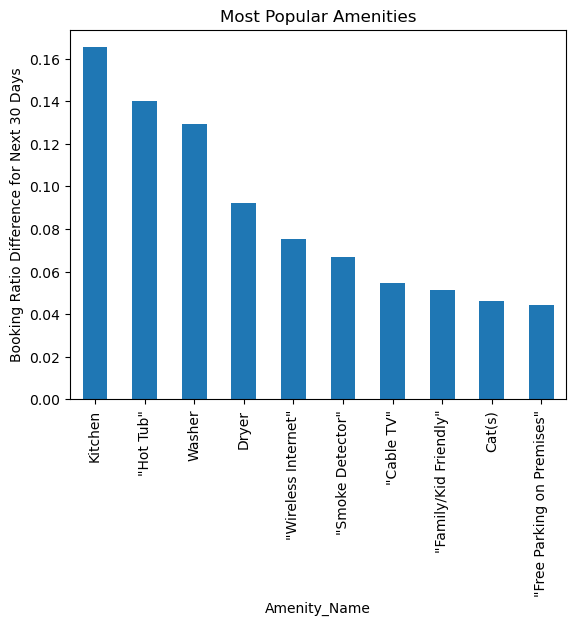

In [118]:
#Here I draw a bar chart to visualize which amenities are most prefered by guests.
amenities_importance['Booking Difference'].sort_values(ascending = False)[:10].plot(kind='bar', legend=None)
plt.title('Most Popular Amenities');
plt.ylabel('Booking Ratio Difference for Next 30 Days')
plt.show()

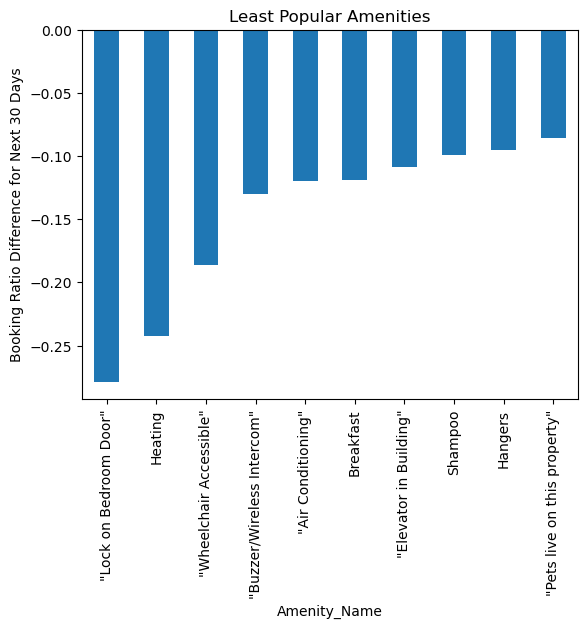

In [119]:
#Here I draw a bar chart to visualize which amenities are least prefered by guests.
amenities_importance['Booking Difference'].sort_values(ascending = True)[:10].plot(kind='bar', legend=None)
plt.title('Least Popular Amenities');
plt.ylabel('Booking Ratio Difference for Next 30 Days')
plt.show()

So for the answer of Question-2 ("What attracts the guests most for renting a property?") we can say that having a Washer/Dryer increases the booking rate for next 30 days more than 15%. Also having a kitchen and allowing pets are good ideas for increasing the popularity for a listing.

Also when comparing different room_types, an "Entire home/apt" is more than 10% more popular than a private room or a shared room.
It looks like having a pool or serving breakfast does not help a listing to be preferred, probably because of the increased price with these amenities.

## 3. Data Preparation

#### Question-3

There are so many features in the dataset, that has effect on the price of the listing. In the third question I would like to train a model to estimate the price of a listing. So the question I would like to answer is: How can we estimate the price of a listing, what are the most influencial features of the dataset to estimate the price of a listing.

First I would like to know about the number of missing values in the features that are related to price.

In [120]:
print(df_lis['price'].isnull().sum())
print(df_lis['weekly_price'].isnull().sum())
print(df_lis['monthly_price'].isnull().sum())
print(df_lis['security_deposit'].isnull().sum())
print(df_lis['cleaning_fee'].isnull().sum())

1
113
160
117
69


There are five different prices in the dataset, which are listed below.
- price
- weekly_price
- monthly_price
- security_deposit
- cleaning_fee

In the code cell above, I find the number of null values in each column. As can be seen, some of the listings do not have weekly or monthly price. So it is a better idea to model the "price" because of larger sample size.
I will not take into account the security deposit and cleaning fee.

In [121]:
#Below, I made a list of important features in my opinion for estimating the price of a listing and created
#a sub-dataframe of listings dataframe.

#In order to answer the first question, I made columns for amenities categorical value, I will use all amenities columns
#I created there.

features_of_interest = ['bathrooms', 'bedrooms', 'beds', 'latitude', 'longitude', 'square_feet', 'reviews_per_month',
        'booking_ratio_30', 'accommodates', 'guests_included', '"24-Hour Check-in"', '"Suitable for Events"',
       '"Pets live on this property"', 'Dog(s)', 
        'Essentials', '"Wireless Internet"',
       '"Buzzer/Wireless Intercom"', 'TV', 'Gym',  
       '"Hot Tub"', '"Air Conditioning"', '"Pets Allowed"', 
       '"Hair Dryer"', '"Fire Extinguisher"', 'Breakfast', 
       '"Laptop Friendly Workspace"', '"Free Parking on Premises"',
       '"Lock on Bedroom Door"', 'Cat(s)', 'Hangers', '"Family/Kid Friendly"',
       '"Carbon Monoxide Detector"', '"Safety Card"', 'Kitchen',
       '"Elevator in Building"', 'Internet', 'Shampoo', '"Smoke Detector"',
       '"Wheelchair Accessible"', 'Iron', '"First Aid Kit"',
       '"Indoor Fireplace"', '"Cable TV"', 'Heating', 'host_is_superhost', 'neighbourhood_group_cleansed',
        'property_type','room_type','bed_type','price','security_deposit',
        'cleaning_fee', 'extra_people', 'instant_bookable', 'cancellation_policy']

df_lis_ml = df_lis[features_of_interest]

#\'"Washer / Dryer"\', \'"Smoking Allowed"\', \'"Other pet(s)"\', \'Doorman\', \'Pool\'

In [122]:
#Now lets check the missing values in each columns and find a way to fill them.

df_lis_ml.isnull().sum()[df_lis_ml.isnull().sum()>0]

square_feet            235
reviews_per_month       37
guests_included          1
price                    1
security_deposit       117
cleaning_fee            69
extra_people             1
instant_bookable         1
cancellation_policy      1
dtype: int64

In [123]:
#Here I drop the 'square_feet' column since there are many missing values and
#columns like beds, bedrooms and bathrooms columns that can replace the square_feet

df_lis_ml = df_lis_ml.drop(columns='square_feet')

In [124]:
df_lis_ml.columns

Index(['bathrooms', 'bedrooms', 'beds', 'latitude', 'longitude',
       'reviews_per_month', 'booking_ratio_30', 'accommodates',
       'guests_included', '"24-Hour Check-in"', '"Suitable for Events"',
       '"Pets live on this property"', 'Dog(s)', 'Essentials',
       '"Wireless Internet"', '"Buzzer/Wireless Intercom"', 'TV', 'Gym',
       '"Hot Tub"', '"Air Conditioning"', '"Pets Allowed"', '"Hair Dryer"',
       '"Fire Extinguisher"', 'Breakfast', '"Laptop Friendly Workspace"',
       '"Free Parking on Premises"', '"Lock on Bedroom Door"', 'Cat(s)',
       'Hangers', '"Family/Kid Friendly"', '"Carbon Monoxide Detector"',
       '"Safety Card"', 'Kitchen', '"Elevator in Building"', 'Internet',
       'Shampoo', '"Smoke Detector"', '"Wheelchair Accessible"', 'Iron',
       '"First Aid Kit"', '"Indoor Fireplace"', '"Cable TV"', 'Heating',
       'host_is_superhost', 'neighbourhood_group_cleansed', 'property_type',
       'room_type', 'bed_type', 'price', 'security_deposit', 'cleaning

There are only 9 columns that have missing values. Here is the strategy that I have for filling each of the columns:
- Almost all of **square_feet** are missing. So I decided to drop that columns since I have columns like beds, bedrooms and bathrooms columns that can replace the square_feet.
- guests_included, price, extra people, instant bookable, cancellation policy have very few missing values. reviews_per_month also has some missing values. Since all these columns are float, I will fill the missing values with the mean of that column.
- security_deposit and cleaning_fee have object data type. I will change this later but for now I want to fill the missing values. The missing values here most probably mean they are equal to zero, so I will fill them with zero.

In [125]:
#Below, I replace the missing values of 4 features (bathrooms, bedrooms, beds and reviews_per_month) with
#mean values of each feature in the dataset.

df_lis_ml['bathrooms'].fillna(df_lis_ml['bathrooms'].mean(), inplace=True)
df_lis_ml['bedrooms'].fillna(df_lis_ml['bedrooms'].mean(), inplace=True)
df_lis_ml['beds'].fillna(df_lis_ml['beds'].mean(), inplace=True)
df_lis_ml['reviews_per_month'].fillna(df_lis_ml['reviews_per_month'].mean(), inplace=True)

In [126]:
#Below, I replace the missing values of 2 features (host_is_superhost and property_type) with
#mode values (most common) of each feature in the dataset.

df_lis_ml['host_is_superhost'].fillna(df_lis_ml['host_is_superhost'].mode()[0], inplace=True)
df_lis_ml['property_type'].fillna(df_lis_ml['property_type'].mode()[0], inplace=True)

In [127]:
#Below, I replace the missing values of 2 features (security_deposit and cleaning_fee) with zeros.
#The missing values in these features most probably mean they are equal to zero

df_lis_ml['security_deposit'].fillna(0, inplace=True)
df_lis_ml['cleaning_fee'].fillna(0, inplace=True)

Now I will check the datatypes, make necessary changes for the datatypes. Also I will have to make new columns for categorical columns.

In [128]:
df_lis_ml.dtypes

bathrooms                       float64
bedrooms                          int64
beds                              int64
latitude                        float64
longitude                       float64
reviews_per_month               float64
booking_ratio_30                float64
accommodates                      int64
guests_included                 float64
"24-Hour Check-in"                int64
"Suitable for Events"             int64
"Pets live on this property"      int64
Dog(s)                            int64
Essentials                        int64
"Wireless Internet"               int64
"Buzzer/Wireless Intercom"        int64
TV                                int64
Gym                               int64
"Hot Tub"                         int64
"Air Conditioning"                int64
"Pets Allowed"                    int64
"Hair Dryer"                      int64
"Fire Extinguisher"               int64
Breakfast                         int64
"Laptop Friendly Workspace"       int64


The following columns have to change from object to float:
- price
- security_deposit
- cleaning_fee

In [129]:
#In the columns that have information about price, the $ signs and (comma) signs has to be removed. 

df_lis_ml['price'] = df_lis_ml['price'].str.replace('$', '')
df_lis_ml['security_deposit'] = df_lis_ml['security_deposit'].str.replace('$', '')
df_lis_ml['cleaning_fee'] = df_lis_ml['cleaning_fee'].str.replace('$', '')
df_lis_ml['extra_people'] = df_lis_ml['extra_people'].str.replace('$', '')

df_lis_ml['price'] = df_lis_ml['price'].str.replace(',', '')
df_lis_ml['security_deposit'] = df_lis_ml['security_deposit'].str.replace(',', '')
df_lis_ml['cleaning_fee'] = df_lis_ml['cleaning_fee'].str.replace(',', '')
df_lis_ml['extra_people'] = df_lis_ml['extra_people'].str.replace(',', '')

#Removing $ and , signs made 0 (zero) values NaN again. So I have to fillna with 0 again. 
df_lis_ml['security_deposit'].fillna(0, inplace=True)
df_lis_ml['cleaning_fee'].fillna(0, inplace=True)

In [130]:
#Changing data type from string to float.
df_lis_ml['price'] = df_lis_ml['price'].astype(float)
df_lis_ml['security_deposit'] = df_lis_ml['security_deposit'].astype(float)
df_lis_ml['cleaning_fee'] = df_lis_ml['cleaning_fee'].astype(float)
df_lis_ml['extra_people'] = df_lis_ml['extra_people'].astype(float)

In [131]:
#creating a new dataframe which is a subset of categorical columns of out df_lis_ml dataframe
cat_cols = df_lis_ml.select_dtypes(include=['object'])

In [132]:
cat_cols.head()

,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,bed_type,instant_bookable,cancellation_policy
0,f,Queen Anne,Apartment,Entire home/apt,Real Bed,f,moderate
1,t,Queen Anne,Apartment,Entire home/apt,Real Bed,f,strict
2,f,Queen Anne,House,Entire home/apt,Real Bed,f,strict
3,f,Queen Anne,Apartment,Entire home/apt,Real Bed,f,flexible
4,f,Queen Anne,House,Entire home/apt,Real Bed,f,strict


In [133]:
# Making new columns from categorical variables in order to use these features in ML regression algoritm.
for col in cat_cols:
    try:
        df_lis_ml = pd.concat([df_lis_ml.drop(col, axis=1), pd.get_dummies(df_lis_ml[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    except:
        continue

Since I made the data ready, I will try Linear Regression to estimate price depending on features I selected.

In [134]:
df_lis_ml.isnull().sum()[df_lis_ml.isnull().sum()>0]

guests_included    1
price              1
extra_people       1
dtype: int64

In [135]:

# few rows can be dropped. 

In [136]:
df_lis_ml.dropna(inplace = True)

In [137]:
df_lis_ml.isnull().sum()[df_lis_ml.isnull().sum()>0]

Series([], dtype: int64)

In [138]:
#Creating the X (feautures) and y (the variable to be modelled) dataframes
y = df_lis_ml['price']
X = df_lis_ml.drop(columns='price')

In [139]:

#Splitting the new dataframes into train and test dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## 4. Modelling

In [140]:
#Applying the linear regression, fitting the model, making predictions with the test set and scoring the success of the model
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)
test_score = r2_score(y_test, y_test_preds)
print(test_score)

0.637591970591777


The r-squared value of my model is 0.637 which is not too high.

I want to investigate about the coefficients of my model. Below function is taken from one of the Udacity jupyter notebook examples. I used this code to see coefficients of my model.

In [141]:

#Below function is taken from one of the Udacity jupyter notebook examples. I used this code to see coefficients of my model. 
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

Below is the list features that are the most influential coefficients. 

In [142]:
coef_df.head(15)

,est_int,coefs,abs_coefs
3,latitude,-3690.235700,3690.235700
4,longitude,-695.254888,695.254888
47,neighbourhood_group_cleansed_Queen Anne,-68.260285,68.260285
27,Cat(s),63.956549,63.956549
10,"""Suitable for Events""",-62.943194,62.943194
49,property_type_Bungalow,-60.586793,60.586793
18,"""Hot Tub""",55.598151,55.598151
12,Dog(s),51.788541,51.788541
42,Heating,-42.413729,42.413729
1,bedrooms,37.577405,37.577405


In order to increase r-squared value I will use SelectKBest.
Below I write a function that tests different "k" numbers and compare r-squared for each k value.

In [143]:
def find_optimal_number_of_selectors(X, y, k_samples, plot=True):
    '''
    INPUT:
    X dataframe that contains the features.
    y dataframe that contains the variable to be predicted.
    k_samples is a list of k values that will be tested.
    
    OUTPUT:
    A dictionary that contains values of tested k-values as keys and r-squared values for each key.
    The k-value that has the highest r-squared.

    '''   
    result_r_squareds = []
    results = {}
    for kes in k_samples:
        selector = SelectKBest(score_func=f_regression, k=kes)
        selector.fit_transform(X, y)
        selected_cols = selector.get_support(indices=True)
        features_new_X = X.iloc[:,selected_cols]
        
        X_train, X_test, y_train, y_test = train_test_split(features_new_X, y, test_size = 0.2, random_state=42)
        lm_model = LinearRegression()
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        result_r_squareds.append(r2_score(y_test, y_test_preds))
        results[str(kes)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(k_samples, result_r_squareds, label="r-squared", alpha=0.5)
        plt.xlabel("Different k_values")
        plt.ylabel("R_Squared_Values")
        plt.legend(loc=1)
        plt.show()
    
    best_k = max(results, key=results.get)
    
    return results, best_k

In [144]:
from sklearn.preprocessing import normalize

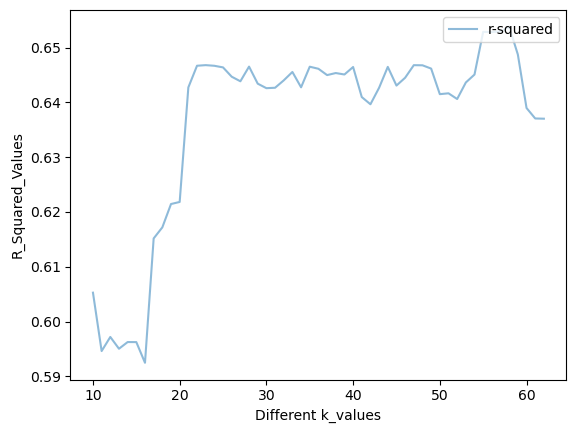

{'10': 0.6052729679193241, '11': 0.5946181889477131, '12': 0.597190523205127, '13': 0.5950416721245969, '14': 0.5962624890823486, '15': 0.596253407375007, '16': 0.5924789140706619, '17': 0.6151714152677917, '18': 0.6171938861383001, '19': 0.6214500145230784, '20': 0.6218284862071801, '21': 0.6427341575740556, '22': 0.6466870369461484, '23': 0.6467972015434069, '24': 0.6466798860969, '25': 0.6463845503086627, '26': 0.6446864737126834, '27': 0.6438494332552295, '28': 0.6465289660399596, '29': 0.6434176762652024, '30': 0.6425929594899343, '31': 0.6426687792569666, '32': 0.6440151900469345, '33': 0.6455502958764825, '34': 0.6427498671299519, '35': 0.6465128595051521, '36': 0.6461335524274805, '37': 0.6449806857075524, '38': 0.6453554773266315, '39': 0.6450890926444062, '40': 0.6464562975600519, '41': 0.6409717204790754, '42': 0.6396550566188023, '43': 0.6426772602793775, '44': 0.6464791144532489, '45': 0.643069846750819, '46': 0.644497264017229, '47': 0.6467922840341975, '48': 0.6467683120

In [145]:
#I test a range of k values from 10 to 94 (which is the number of all features)
#and find the number of features that generate the highest r-squared value.
k_samples = range(10, len(X.columns))
emre_results, emre_best_k = find_optimal_number_of_selectors(X, y, k_samples)
print(emre_results)
print(emre_best_k)
print(emre_results[emre_best_k])

The highest r-squared value is achieved with 79 features and the r-squared value is 0,6244

#### Question-4

In the dataset we have latitude and longitude that gives information about the location of the listing. I would like to investigate effect of listings' proximity to Seattle Downtown. Does it increase the price or decrease the price to be close to downtown. And how much does it effect the price? This is my final question to answer.

Below I write a function that calculate the distance from downtown. According to Google Maps the coordinates of Seattle downtown are [47.605151, -122.334379] This is the coordinate that I will calculate the distance of every listing.

In [146]:
def distance_from_downtown(lat, lon, downtown=[47.605151, -122.334379]):
    '''
    INPUT:
    lat is the latitude of the point that I will calculate distance.
    lon is the longitude of the point that I will calculate distance.
    downtown is the coordinate of Seattle Downtown according to Google Maps. Downtown variable can be different, if the
    distance is expected to be calculated from a different point.
    
    OUTPUT:
    Distance between the point and the downtown.
    '''   
    R = 6373.0
    lat1 = math.radians(downtown[0])
    lon1 = math.radians(downtown[1])
    lat2 = math.radians(lat)
    lon2 = math.radians(lon)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [147]:
#Below I make a for look to calculate the distance of each listing from downtown.
#I create a new variable called 'distance_from_downtown' which has the information of distance of listing from downtown. 
for i in range(len(df_lis_ml)):
    df_lis_ml.loc[ i , 'distance_from_downtown'] = distance_from_downtown(df_lis_ml.loc[ i ,'latitude'] , df_lis_ml.loc[ i ,'longitude'])

In [148]:
#Since we added a distance variable, we do not need 'latitude', 'longitude' columns.
df_lis_ml.drop(columns=['latitude', 'longitude'], inplace=True)

Lets make another regression model with distance from downtown variable.

In [149]:
#Creating the X (feautures) and y (the variable to be modelled) dataframes
y = df_lis_ml['price']
X = df_lis_ml.drop(columns='price')

In [150]:
#Splitting the new dataframes into train and test dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [151]:
#Applying the linear regression, fitting the model, making predictions with the test set and scoring the success of the model
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)
test_score = r2_score(y_test, y_test_preds)
print(test_score)

0.6340285027737984


In [152]:
#Previously I had written a function above to see coefficients of my regression model.
#The name of the function was "coef_weights"

#I use the function again to find the coefficients of the new model.
coef_df = coef_weights(lm_model.coef_, X_train)

## 5.Evaluation

In [153]:
#I print the coefficient of 'distance_from_downtown' variable
coef_df[coef_df['est_int'] == 'distance_from_downtown']

,est_int,coefs,abs_coefs
61,distance_from_downtown,-9.694045,9.694045


As can be seen above, the 'distance_from_downtown' feature has a negative effect on price. As the distance from downtown increases, the price of listing decreases. For one kilometer additional distance from downtown, the price of listing decrease around 3 USD. 